Convention: 

Image input type: uint8 (if possible)

Output image: uint8


# Distributions

## Normal

In [ ]:
import numpy as np
class MarginalConditionalMultivariateNormal:
  def __init__(self,mu,cov):
    self.cov=cov
    self.dim=cov.shape[0]
    self.mu=mu.reshape((self.dim,1))

  def marginal(self,indices):
    mu = self.mu[indices]
    cov = self.cov[indices,:][:,indices]
    return mu, cov

  def conditional(self,xWithNas,computeCov=False):
    xWithNas = xWithNas.reshape((self.dim,1))
    indices = np.isnan(xWithNas).squeeze()
    knownIndices = np.logical_not(indices)
    auxMatrix = np.matmul(self.cov[indices,:][:,knownIndices],
         np.linalg.inv(self.cov[knownIndices,:][:,knownIndices]))
    mu = self.mu[indices] + np.matmul(
        auxMatrix,
        xWithNas[knownIndices] - self.mu[knownIndices])
    cov = None
    if computeCov:
      cov = self.cov[indices,:][:,indices] - np.matmul(
          auxMatrix,
          self.cov[indices,:][:,knownIndices].T)
    return mu,cov

# mu = np.array([0.0,1.0,2.0])
# cov = np.array([[1.0,0.0,0.5],
#                 [0.0,2.0,0.5],
#                 [0.5,0.5,3.0]])
# print(MarginalConditionalMultivariateNormal(mu,cov).marginal(np.array([True,False,True])))
# print(MarginalConditionalMultivariateNormal(mu,cov).conditional(np.array([[0.0,np.nan,np.nan]])))

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
class MarginalConditionalGmm:
  def __init__(self,pis,mus,covs):
    self.pis = pis
    self.mus = [mu.reshape((-1,)) for mu in mus]
    self.covs = covs
    self.dim = covs[0].shape[0]
    self.k = len(pis)
    self.distributions = [MarginalConditionalMultivariateNormal(self.mus[i],self.covs[i]) for i in range(self.k)]
  
  def marginal(self,indices):
    pis = self.pis.copy()
    mus = [None]*self.k
    covs = [None]*self.k
    for i in range(self.k):
      mus[i], covs[i] = self.distributions[i].marginal(indices) 
    return pis,mus,covs

  def conditional(self,xWithNas,ifErrorReplaceByDistance=True,lambdaIdentity = 0):
    xWithNas = xWithNas.reshape((self.dim,))
    indices = np.isnan(xWithNas).squeeze()
    knownIndices = np.logical_not(indices)
    pis = self.pis.copy()
    mus = [None]*self.k
    covs = [None]*self.k
    for i in range(self.k):
      # if self.k != 1:
      #   auxMu, auxCov = self.distributions[i].marginal(knownIndices)
        
        # prob = tfd.MultivariateNormalFullCovariance(
        #     loc=auxMu.reshape((-1,)),
        #     covariance_matrix=auxCov + np.identity(np.sum(knownIndices))).prob(xWithNas[knownIndices]).numpy()
        
        # prob = multivariate_normal.pdf(
        #     xWithNas[knownIndices],
        #     auxMu.reshape((-1,)),
        #     auxCov + np.identity(np.sum(knownIndices))*lambdaIdentity )
        # print(prob)
        # if prob < 1e-50 or prob > 1e50:
        #   if ifErrorReplaceByDistance:
        #     print("pdf replaced by inverted distance")
        #     prob = 1/np.sqrt(np.sum((auxMu.reshape((-1,)) - xWithNas[knownIndices])**2))
        #   else:
        #     print("pdf replaced by 1 => initial GMM weights")
        #     prob = 1
      pis[i] = self.pis[i] #* prob
        # print( np.sqrt(np.sum((auxMu.reshape((-1,)) - xWithNas[knownIndices])**2)) )
        # import tensorflow_probability as tfp
        # tfd = tfp.distributions
        # fff = tfd.MultivariateNormalFullCovariance(
        #     loc=auxMu.reshape((-1,)),
        #     covariance_matrix=auxCov + np.identity(np.sum(knownIndices))).prob(xWithNas[knownIndices]).numpy()
        # print(fff)
        # pis[i] = self.pis[i] * fff

      mus[i], covs[i] = self.distributions[i].conditional(xWithNas)
    # marginalPis,marginalMus,marginalCovs = self.marginal(knownIndices)
    pis /= np.sum(pis)
    return pis,mus,covs

# d = 128

# mu = np.random.rand(d*d).astype(np.float32)
# cov = np.identity(d*d).astype(np.float32)
# pis = np.array([1.0],dtype=np.float32)
# mus=np.array([mu],dtype=np.float32)
# covs=np.array([cov],dtype=np.float32)
# indices = np.random.rand(d*d).astype(np.float32) > 0.5
# x = np.random.rand(d*d).astype(np.float32)
# x[indices] = np.nan
# obj=MarginalConditionalGmm(pis,mus,covs)
# print(x.dtype)
# del mu
# del cov
# del mus
# del covs
# print("what")
# print(obj.marginal(indices))
# print(obj.conditional(x))

# mu = np.array([0.0,1.0,2.0])
# cov = np.array([[1.0,0.0,0.5],
#                 [0.0,2.0,0.5],
#                 [0.5,0.5,3.0]])
# pis = np.array([1.0])
# mus=np.array([mu])
# covs=np.array([cov])
# print(MarginalConditionalGmm(pis,mus,covs).marginal(np.array([True,False,True])))
# print(MarginalConditionalGmm(pis,mus,covs).conditional(np.array([[0.0,np.nan,np.nan]])))

## Matrix Normal Distribution

In [ ]:
import numpy as np

class MatrixNormalDistribution:
  def __init__(self,M,U,V):
    self.M=M
    self.U=U
    self.V=V
  def _swapRows(self,rangeSourceFull,rangeSourceTrimmed,
                rangeDestinationFull,rangeDestinationTrimmed,X=None):
    # X
    if X is not None:
      aux = X[rangeDestinationTrimmed,:].copy()
      X[rangeDestinationFull,:] = X[rangeSourceFull,:]
      X[rangeSourceTrimmed,:] = aux
    
    # M
    aux = self.M[rangeDestinationTrimmed,:].copy()
    self.M[rangeDestinationFull,:] = self.M[rangeSourceFull,:]
    self.M[rangeSourceTrimmed,:] = aux
    
    # U
    aux = self.U[rangeDestinationTrimmed,:].copy()
    self.U[rangeDestinationFull,:] = self.U[rangeSourceFull,:]
    self.U[rangeSourceTrimmed,:] = aux

    aux = self.U[:,rangeDestinationTrimmed].copy()
    self.U[:,rangeDestinationFull] = self.U[:,rangeSourceFull]
    self.U[:,rangeSourceTrimmed] = aux

    # V - the same
  
  def _swapColumns(self,rangeSourceFull,rangeSourceTrimmed,
                rangeDestinationFull,rangeDestinationTrimmed,X=None):
    # X
    if X is not None:
      aux = X[:,rangeDestinationTrimmed].copy()
      X[:,rangeDestinationFull] = X[:,rangeSourceFull]
      X[:,rangeSourceTrimmed] = aux
    
    # M
    aux = self.M[:,rangeDestinationTrimmed].copy()
    self.M[:,rangeDestinationFull] = self.M[:,rangeSourceFull]
    self.M[:,rangeSourceTrimmed] = aux
    
    # U - the same

    # V
    aux = self.V[:,rangeDestinationTrimmed].copy()
    self.V[:,rangeDestinationFull] = self.V[:,rangeSourceFull]
    self.V[:,rangeSourceTrimmed] = aux

    aux = self.V[rangeDestinationTrimmed,:].copy()
    self.V[rangeDestinationFull,:] = self.V[rangeSourceFull,:]
    self.V[rangeSourceTrimmed,:] = aux

  def moveRectangleToBottomRight(self,topLeftRow,topLeftColumn,
                                 bottomRightRow,bottomRightColumn,X=None):
    # move [topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn]
    nRows = self.M.shape[0]
    nColumns = self.M.shape[1]
    
    rowDiff = bottomRightRow - topLeftRow
    
    rangeSourceFull = range(topLeftRow,bottomRightRow)
    rangeDestinationFull = range(nRows - rowDiff,nRows)

    if bottomRightRow > nRows - rowDiff:
      rangeSourceTrimmed = range(topLeftRow,topLeftRow + nRows - bottomRightRow)
      rangeDestinationTrimmed = range(bottomRightRow,nRows)
    else:
      rangeSourceTrimmed = rangeSourceFull
      rangeDestinationTrimmed = rangeDestinationFull

    self._swapRows(rangeSourceFull,rangeSourceTrimmed,rangeDestinationFull,rangeDestinationTrimmed,X)

    columnDiff = bottomRightColumn - topLeftColumn

    rangeSourceFull = range(topLeftColumn,bottomRightColumn)
    rangeDestinationFull = range(nColumns - columnDiff,nColumns)

    if bottomRightColumn > nColumns - columnDiff:
      rangeSourceTrimmed = range(topLeftColumn,topLeftColumn + nColumns - bottomRightColumn)
      rangeDestinationTrimmed = range(bottomRightColumn,nColumns)
    else:
      rangeSourceTrimmed = rangeSourceFull
      rangeDestinationTrimmed = rangeDestinationFull

    self._swapColumns(rangeSourceFull,rangeSourceTrimmed,rangeDestinationFull,rangeDestinationTrimmed,X)

  def __str__(self):
    return "M:\n"+np.array2string(self.M) + "\nU:\n" + np.array2string(self.U) + "\nV:\n" + np.array2string(self.V) 
  def __repr__(self):
    return "M:\n"+np.array2string(self.M) + "\nU:\n" + np.array2string(self.U) + "\nV:\n" + np.array2string(self.V) 

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# print(distribution)
# distribution.moveRectangleToBottomRight(0,0,4,5)
# print(distribution)

In [ ]:
class MarginalConditionalMatrixNormal:

  def __init__(self,distribution):
    self.distribution=distribution

  def marginal(self,indicesRow,indicesColumn):
    return MatrixNormalDistribution(
      M = self.distribution.M[indicesRow,:][:,indicesColumn],
      U = self.distribution.U[indicesRow,:][:,indicesRow],
      V = self.distribution.V[indicesColumn,:][:,indicesColumn]
    )

  def conditional(self,X,row,column,returnWhat="row"): # "row","column","both"
    # X[row:,column:] - unknown (NA); the other parts are known!
    # [row:,:] - rowDistribution
    # [:,column:] - columnDistribution

    rowDistribution = None
    if returnWhat == "row" or returnWhat == "both":
      auxRow = self.distribution.U[row:,:row].dot(
          np.linalg.inv(self.distribution.U[:row,:row])
      )
      U = self.distribution.U[row:,row:] - auxRow.dot(self.distribution.U[:row,row:])
      V = self.distribution.V
      rowDistribution = MatrixNormalDistribution(
          M = self.distribution.M[row:,:] + 
            auxRow.dot(X[:row,:] - self.distribution.M[:row,:]),
          U = U,
          V = V
      )

    columnDistribution = None
    if returnWhat == "column" or returnWhat == "both":
      auxColumn = np.linalg.inv(self.distribution.V[:column,:column]).dot(
          self.distribution.V[:column,column:]
      )
      columnDistribution = MatrixNormalDistribution(
          M = self.distribution.M[:,column:] + 
            (X[:,:column] - self.distribution.M[:,:column]).dot(auxColumn),
          U = self.distribution.U,
          V = self.distribution.V[column:,column:] - 
            self.distribution.V[column:,:column].dot(auxColumn)
      )

    return rowDistribution, columnDistribution

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# print(distribution)
# obj = MarginalConditionalMatrixNormal(distribution)

# print(obj.marginal([True,True,False,True],[True,True,True,True,False]))

# X = np.random.rand(4,5)
# print(obj.conditional(X,0,2))

In [ ]:
import numpy as np
class MarginalConditionalMatrixGmm:
  def __init__(self,pis,distributions):
    self.pis = pis
    self.numberOfRows = distributions[0].distribution.M.shape[0]
    self.numberOfColumns = distributions[0].distribution.M.shape[1]
    self.k = len(pis)
    self.distributions = distributions
  
  def marginal(self,indicesRow,indicesColumn):
    pis = self.pis.copy()
    distributions = [None]*self.k
    for i in range(self.k):
      distributions[i] = self.distributions[i].marginal(indicesRow,indicesColumn) 
    return pis,distributions

  def conditional(self,X,row,column,lambdaIdentity = 0):
    # USES A HEURISTIC: pis = self.pis!!! IT IS NOT COMPUTED EXACTLY
    # X[row:,column:] - unknown (NA); the other parts are known!
    # [row:,:] - rowDistribution
    # [:,column:] - columnDistribution
    pis = self.pis.copy()
    distributions = [None]*self.k
    for i in range(self.k):
      distributions[i] = self.distributions[i].conditional(X,row,column)
    return pis,distributions

# nr = 4
# nc = 5
# M = np.random.rand(nr,nc)
# U = np.random.rand(nr,nr)
# U = U.dot(U.T)
# V = np.random.rand(nc,nc)
# V = V.dot(V.T)

# distribution = MatrixNormalDistribution(M,U,V)
# # print(distribution)
# obj = MarginalConditionalMatrixNormal(distribution)

# print(obj.marginal([True,True,False,True],[True,True,True,True,False]))

# X = np.random.rand(4,5)
# print(obj.conditional(X,0,2))

# pis = np.array([1.0])
# distributions = [
#   MarginalConditionalMatrixNormal(
#       MatrixNormalDistribution(M,U,V)
#       )
# ]

# print(MarginalConditionalMatrixGmm(pis,distributions).marginal([True,True,False,True],[True,True,True,True,False]))

# print(MarginalConditionalMatrixGmm(pis,distributions).conditional(X,0,2))

## PixelCNN

-

# Sample Data

In [ ]:
import numpy as np
import tensorflow.compat.v1 as tf
mnist = tf.keras.datasets.mnist

# (x_train, y_train),(x_test, y_test) = mnist.load_data()
# data = x_train[:5000,:,:]

# Fit Distributions

In [ ]:
class FitDistribution:
  def fit(self):
    pass
  def _emAlgorithm(self):
    pass
  def _simpleAlgorithm(self):
    pass

## Normal

In [ ]:
from sklearn import mixture
class FitNormalDistribution(FitDistribution):
  def __init__(self,data,k,ridge=0.0):
    self.k = k
    self.ridge=ridge
    self.shape = data.shape[1:]
    if data.dtype == "uint8":
      data = data.astype(np.float32)/255.
    data = data.reshape((data.shape[0],-1))
    self.data = data
  
  def fit(self,maxEmIterations=100):
    if self.k == 1:
      return self._simpleAlgorithm()
    return self._emAlgorithm(maxEmIterations)
  
  def _simpleAlgorithm(self):
    mu=np.mean(self.data,axis=0)
    cov = np.cov(self.data.T) + np.identity(self.data.shape[1])*self.ridge
    return self.shape,np.array([1.0],dtype=np.float32),np.array([mu],dtype=np.float32),np.array([cov],dtype=np.float32)
  
  def _emAlgorithm(self,maxEmIterations):
    gmm = mixture.GaussianMixture(n_components=self.k,
                                  max_iter=maxEmIterations,
                                  verbose=1)
    gmm.fit(self.data)
    for i in range(self.k):
      gmm.covariances_[i] = gmm.covariances_[i] + np.identity(self.data.shape[1]) * self.ridge
    return self.shape,gmm.weights_.astype(np.float32),gmm.means_.astype(np.float32),gmm.covariances_.astype(np.float32)

# fitNormalDistribution = FitNormalDistribution(data,1)
# r1 = fitNormalDistribution.fit()

# fitNormalDistribution = FitNormalDistribution(data,2)
# r2 = fitNormalDistribution.fit(maxEmIterations=100)

In [ ]:
class FitNormalDistributionChannels:
  def __init__(self,data,k,ridge=0.0):
    self.k = k
    self.ridge=ridge
    # if len(data.shape) != 4:
    #   raise Exception("Data is not 3D.")
    self.data = data
  
  def fit(self,maxEmIterations=100):
    nChannels = 1
    if len(self.data.shape) == 4:
      nChannels = self.data.shape[3]

    if nChannels == 1:
      return [FitNormalDistribution(self.data,self.k,self.ridge).fit(maxEmIterations=maxEmIterations)]
    
    rList = [None]*nChannels
    for i in range(nChannels):
      r = FitNormalDistribution(self.data[...,i],self.k,self.ridge).fit(maxEmIterations=maxEmIterations)
      rList[i]=r
    return rList

# fitNormalDistribution = FitNormalDistributionChannels(data,1)
# r1 = fitNormalDistribution.fit()

## Matrix Normal Distribution

In [ ]:
# from scipy.stats import matrix_normal
class FitMatrixNormalDistribution(FitDistribution):
  def __init__(self,data,k,maxNumberOfEpochs = 10, threshold = 1e-6, ridge = 0.0):
    self.k = k
    self.maxNumberOfEpochs = maxNumberOfEpochs
    self.threshold = threshold
    self.ridge=ridge
    if data.dtype == "uint8":
      data = data.astype(np.float32)/255.
    self.data = data
  
  def fit(self,maxEmIterations=100):
    if self.k == 1:
      return self._simpleAlgorithm()
    return self._emAlgorithm(maxEmIterations)

  def _simpleAlgorithm(self):
    data = self.data
    M = np.mean(data,axis=0)
    U = np.cov(data.reshape(-1,data.shape[2]).T) + self.ridge*np.identity(M.shape[0]).astype(np.float32) # not used!
    V = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T) + self.ridge*np.identity(M.shape[1]).astype(np.float32)
    for epoch in range(self.maxNumberOfEpochs):
      print(epoch)
      oldU = U
      oldV = V
      U = 0
      V_inv = np.linalg.inv(V)
      for X in data:
        U += 1/(data.shape[2]*data.shape[0])*np.matmul(X - M,
                            np.matmul(
                                V_inv,
                                (X - M).T)) 
      U = U + self.ridge*np.identity(M.shape[0]).astype(np.float32)
      V = 0
      U_inv = np.linalg.inv(U)
      for X in data:
        V += 1/(data.shape[1]*data.shape[0])*np.matmul((X - M).T,
                                                      np.matmul(
                                                          U_inv,
                                                          X - M
                                                      )) 
      V = V + self.ridge*np.identity(M.shape[1]).astype(np.float32)
      error1 = np.linalg.norm(U - oldU)/np.linalg.norm(oldU)
      error2 = np.linalg.norm(V - oldV)/np.linalg.norm(oldV)
      print(error1)
      print(error2)
      if error1 < self.threshold and error2 < self.threshold:
        break
    return np.array([1.0],dtype=np.float32),np.array([M],dtype=np.float32),np.array([U],dtype=np.float32),np.array([V],dtype=np.float32)
  
  def _emAlgorithm(self,maxEmIterations):
    data = self.data
    n = data.shape[0]
    # initialization
    pis = [None]*self.k
    Ms = [None]*self.k
    Us = [None]*self.k
    Vs = [None]*self.k
    simpleU = np.cov(data.reshape(-1,data.shape[2]).T) + self.ridge*np.identity(data.shape[1]).astype(np.float32) # not used!
    simpleV = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T) + self.ridge*np.identity(data.shape[2]).astype(np.float32)

    # E step
    E = np.random.rand(n,self.k)
    for i in range(n):
      E[i,:] = E[i,:]/np.sum(E[i,:])# matrix_normal.pdf(data[i,:,:], mean=M, rowcov=U, colcov=V)
    for iteration in range(maxEmIterations):
      print("EM Iteration: ",iteration)
      # M step
      for j in range(self.k):
        pis[j] = np.mean(E[:,j])
        Ms[j] = np.average(data,axis=0,weights=E[:,j])
        # print(data.reshape(-1,data.shape[2]).T.shape)
        # print(E[:,j].shape)
        # Us[j] = np.cov(data.reshape(-1,data.shape[2]).T,aweights=E[:,j]) + self.ridge*np.identity(Ms[j].shape[0]).astype(np.float32) # not used!
        # Vs[j] = np.cov(data.swapaxes(1,2).reshape(-1,data.shape[1]).T,aweights=E[:,j]) + self.ridge*np.identity(Ms[j].shape[1]).astype(np.float32)
        if iteration == 0:
          Us[j] = simpleU
          Vs[j] = simpleV
        print("\tcluster ",j)
        for epoch in range(self.maxNumberOfEpochs):
          print("\tU/V Epoch: ", epoch)
          oldU = Us[j]
          oldV = Vs[j]
          U = 0
          V_inv = np.linalg.inv(Vs[j])
          auxSum = np.sum(E[:,j])
          for i in range(data.shape[0]):
            X = data[i,:,:]
            U += 1/(data.shape[2]*auxSum) * E[i,j] * np.matmul(X - Ms[j],
                                np.matmul(
                                    V_inv,
                                    (X - Ms[j]).T)) 
          U = U + self.ridge*np.identity(Ms[j].shape[0]).astype(np.float32)
          V = 0
          U_inv = np.linalg.inv(U)
          for i in range(data.shape[0]):
            X = data[i,:,:]
            V += 1/(data.shape[1]*auxSum)*E[i,j]*np.matmul((X - Ms[j]).T,
                                                          np.matmul(
                                                              U_inv,
                                                              X - Ms[j]
                                                          )) 
          V = V + self.ridge*np.identity(Ms[j].shape[1]).astype(np.float32)
          Us[j]=U
          Vs[j]=V
          error1 = np.linalg.norm(U - oldU)/np.linalg.norm(oldU)
          error2 = np.linalg.norm(V - oldV)/np.linalg.norm(oldV)
          print("\t\t",error1)
          print("\t\t",error2)
          if error1 < self.threshold and error2 < self.threshold:
            print("\tU/V: exited via threshold")
            break
        # print("\tU/V: exited via maxIterations")
      newParameters = np.concatenate([np.array(pis),np.array(Ms).reshape((-1,)),np.array(Us).reshape((-1,)),np.array(Vs).reshape((-1,))])
      if iteration != 0:
        error = np.linalg.norm(newParameters - oldParameters)/np.linalg.norm(oldParameters)
        print(error)
        if error < self.threshold:
          print("exited via threshold")
          break
      oldParameters = newParameters
    # print("exited via maxIterations")
        
    return np.array(pis,dtype=np.float32),np.array(Ms,dtype=np.float32),np.array(Us,dtype=np.float32),np.array(Vs,dtype=np.float32)
    # gmm = mixture.GaussianMixture(n_components=self.k)
    # gmm.fit(self.data)
    # for i in range(self.k):
    #   gmm.covariances_[i] = gmm.covariances_[i] + np.identity(self.data.shape[1]) * self.ridge
    # return gmm.weights_.astype(np.float32),gmm.means_.astype(np.float32),gmm.covariances_.astype(np.float32)

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 10, 
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r12 = fitMatrixNormalDistribution.fit()

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 10, 
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r22 = fitMatrixNormalDistribution.fit(maxEmIterations=2)

In [ ]:
class FitMatrixNormalDistributionChannels:
  def __init__(self,data,k,maxNumberOfEpochs = 10, threshold = 1e-6, ridge = 0.0):
    self.k = k
    self.maxNumberOfEpochs = maxNumberOfEpochs
    self.threshold = threshold
    self.ridge=ridge
    # if len(data.shape) != 4:
    #   raise Exception("Data is not 3D.")
    self.data = data
  
  def fit(self,maxEmIterations=100):
    nChannels = 1
    if len(self.data.shape) == 4:
      nChannels = self.data.shape[3]
    
    if nChannels == 1:
      return [FitMatrixNormalDistribution(
          self.data,self.k,
          maxNumberOfEpochs = self.maxNumberOfEpochs,
          threshold = self.threshold, 
          ridge = self.ridge
      ).fit(maxEmIterations=maxEmIterations)]

    rList = [None]*nChannels
    for i in range(nChannels):
      r = FitMatrixNormalDistribution(
          self.data[...,i],self.k,
          maxNumberOfEpochs = self.maxNumberOfEpochs,
          threshold = self.threshold, 
          ridge = self.ridge
      ).fit(maxEmIterations=maxEmIterations)
      rList[i] = r
    return rList

## PixelCNN

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
tfd = tfp.distributions

tf.disable_eager_execution()

class FitPixelCnnlDistribution(FitDistribution):
  def __init__(self,data,k,
               batchSize=16, nEpochs=10, num_resnet=1,
                num_hierarchies=2,
                num_filters=32,
                num_logistic_mix=5,
                dropout_p=.3,
                optimizer = tf.train.AdamOptimizer()):
    tf.reset_default_graph()
    self.k = k
    self.batchSize = batchSize
    self.nEpochs = nEpochs
    if len(data.shape) == 3:
      data = data[...,np.newaxis]
    self.n = data.shape[0]
    self.shape = data.shape[1:]
    self.num_resnet = num_resnet
    self.num_hierarchies = num_hierarchies
    self.num_filters=num_filters
    self.num_logistic_mix=num_logistic_mix
    self.dropout_p=dropout_p
    if data.dtype == "uint8":
      data = data.astype(np.float32)
    else:
      data = (data * 255).astype(np.float32)
    self.dataset = tf.data.Dataset.from_tensor_slices(data)
    self.optimizer = optimizer
  
  def fit(self):
    batch_size = self.batchSize
    train_it = self.dataset.batch(self.batchSize).shuffle(1000).repeat()

    iterator = train_it.make_initializable_iterator()
    # extract an element
    next_element = iterator.get_next()

    # Define a Pixel CNN network
    # dist = tfd.PixelCNN(
    #     image_shape=self.shape,
    #     num_resnet=self.num_resnet,
    #     num_hierarchies=self.num_hierarchies,
    #     num_filters=self.num_filters,
    #     num_logistic_mix=self.num_logistic_mix,
    #     dropout_p=self.dropout_p,
    #     high=255, low=0
    # )

    k = self.k
    pis = tf.nn.softmax(tf.Variable(([0.]*k),dtype=tf.float32))
    distributions = [
        tfd.PixelCNN(
        image_shape=self.shape,
        num_resnet=self.num_resnet,
        num_hierarchies=self.num_hierarchies,
        num_filters=self.num_filters,
        num_logistic_mix=self.num_logistic_mix,
        dropout_p=self.dropout_p,
        high=255, low=0
        ) for _ in range(k)
    ]
    mixture = tfd.Mixture(
      cat=tfd.Categorical(probs=pis),
      components=distributions)

    log_loss = -tf.reduce_sum(mixture.log_prob(next_element))

    train_ops = self.optimizer.minimize(log_loss)

    init_op = tf.global_variables_initializer()

    nBatches = int(self.n/batch_size)
    nEpochs = self.nEpochs

    probs = None
    sess = tf.Session()
    sess.run(init_op)
    sess.run(iterator.initializer)
    for i in range(nEpochs):
      lossEpoch = 0
      # if i == 1:
      # print(len(sess.run(distributions[0].variables)))
      # print(len(sess.run(mixture.variables)))
      # print(sess.run(distributions[0].variables)[10])
      # print(sess.run(mixture.variables)[10])
      for batch in range(nBatches):
        z = sess.run(train_ops)
        loss = sess.run(log_loss)
        probs = sess.run(pis)
        lossEpoch+=loss
      if (i+1) % 1 == 0:
        # import pickle
        # pickle.dump(sess.run(dist.variables),open('drive/My Drive/colab/variables.pkl','wb'))
        print(str(i+1) + " : " + str(lossEpoch))
    result = [sess.run(distributions[j].variables) for j in range(k)]
    arguments = {
        'image_shape':self.shape,
        'num_resnet':self.num_resnet,
        'num_hierarchies':self.num_hierarchies,
        'num_filters':self.num_filters,
        'num_logistic_mix':self.num_logistic_mix,
        'dropout_p':self.dropout_p
    }
      # serialize((arguments,np.array(probs,dtype=np.float32),result,distributions,sess,mixture),
      #           dataName,distributionName,str(k)+"_{}".format(i))
    return arguments,np.array(probs,dtype=np.float32),result,distributions,sess,mixture

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],1,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r1 = fitPixelCnnlDistribution.fit()

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],2,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r2 = fitPixelCnnlDistribution.fit()

# Sample from Distribution

In [ ]:
class SampleFromDistribution:
  def sample(self,fitDistribution,plot=True):
    pass

## Normal

In [ ]:
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
class SampleFromNormalDistribution(SampleFromDistribution):
  def sample(self,fitDistributionResult,plot=True):
    j = np.random.choice(  
     a=list(range(len(fitDistributionResult[1]))),  
     size=1,
     p=fitDistributionResult[1]
    )[0]

    image = multivariate_normal.rvs(
        mean=fitDistributionResult[2][j], 
        cov=fitDistributionResult[3][j]).reshape(fitDistributionResult[0])
    image = np.clip(image,0,1)
    image = (image*255.0).astype(np.uint8)
    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# fitNormalDistribution = FitNormalDistribution(data,1)
# r1 = fitNormalDistribution.fit()
# image = SampleFromNormalDistribution().sample(r1)

# fitNormalDistribution = FitNormalDistribution(data,2)
# r2 = fitNormalDistribution.fit(maxEmIterations=100)
# image = SampleFromNormalDistribution().sample(r2)

In [ ]:
class SampleFromNormalDistributionChannels:
  def sample(self,fitDistributionResult,plot=True):
    nChannels = len(fitDistributionResult)
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = SampleFromNormalDistribution().sample(fitDistributionResult[i],plot=False)
      imageList[i] = image
    
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image

# r1 = FitNormalDistributionChannels(data,1).fit()
# image = SampleFromNormalDistributionChannels().sample(r1)

# fitNormalDistribution = FitNormalDistribution(data,1)
# r1 = fitNormalDistribution.fit()
# image = SampleFromNormalDistribution().sample(r1)

## Matrix Normal Distribution

In [ ]:
from scipy.stats import matrix_normal
import matplotlib.pyplot as plt
class SampleFromMatrixNormalDistribution(SampleFromDistribution):
  def sample(self,fitDistributionResult,plot=True):
    j = np.random.choice(  
     a=list(range(len(fitDistributionResult[0]))),  
     size=1,
     p=fitDistributionResult[0]
    )[0]
    image = matrix_normal.rvs(
        mean=fitDistributionResult[1][j], 
        rowcov=fitDistributionResult[2][j],
        colcov=fitDistributionResult[3][j]).reshape(fitDistributionResult[1][0].shape)
    image = np.clip(image,0,1)
    image = (image*255.0).astype(np.uint8)
    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 
# image = SampleFromMatrixNormalDistribution().sample(r11)

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 
# image = SampleFromMatrixNormalDistribution().sample(r21)

In [ ]:
class SampleFromMatrixNormalDistributionChannels:
  def sample(self,fitDistributionResult,plot=True):
    nChannels = len(fitDistributionResult)
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = SampleFromMatrixNormalDistribution().sample(fitDistributionResult[i],plot=False)
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# r11 = FitMatrixNormalDistributionChannels(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# ).fit() 
# image = SampleFromMatrixNormalDistributionChannels().sample(r11)

## PixelCNN

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

def recoverPixelCnn(arguments,result):
  print("recover")
  tf.reset_default_graph()

  dist = tfd.PixelCNN(
      image_shape=arguments['image_shape'],
      num_resnet=arguments['num_resnet'],
      num_hierarchies=arguments['num_hierarchies'],
      num_filters=arguments['num_filters'],
      num_logistic_mix=arguments['num_logistic_mix'],
      dropout_p=arguments['dropout_p'],
      high=255, low=0
  )

  variables = result

  # with tf.Session() as sess:
  sess=tf.Session()
  sess.run(tf.global_variables_initializer())

  # restore "dist":
  counter=0
  for v in dist.variables:
    sess.run(v.assign(variables[counter]))
    counter+=1
  
  return dist,sess

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

def recoverMixturePixelCnn(arguments,pis,result):
  tf.reset_default_graph()

  k = len(pis)
  distributions = [
      tfd.PixelCNN(
      image_shape=arguments['image_shape'],
      num_resnet=arguments['num_resnet'],
      num_hierarchies=arguments['num_hierarchies'],
      num_filters=arguments['num_filters'],
      num_logistic_mix=arguments['num_logistic_mix'],
      dropout_p=arguments['dropout_p'],
      high=255, low=0
      ) for _ in range(k)
  ]
  mixture = tfd.Mixture(
    cat=tfd.Categorical(probs=pis),
    components=distributions)

  # with tf.Session() as sess:
  sess=tf.Session()
  sess.run(tf.global_variables_initializer())

  # restore "mixture":
  counter=0
  for j in range(k):
    variables = result[j]
    for i in range(len(variables)):
      sess.run(mixture.variables[counter].assign(variables[i]))
      counter+=1

  return mixture,sess

In [ ]:
# %%time
import tensorflow.compat.v1 as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfd = tfp.distributions

import matplotlib.pyplot as plt
class SampleFromPixelCnnDistribution(SampleFromDistribution):
  def sample(self,fitDistributionResult,plot=True):
    # j = np.random.choice(  
    #  a=list(range(len(fitDistributionResult[1]))),  
    #  size=1,
    #  p=fitDistributionResult[1]
    # )[0]
    self.fitDistribution=fitDistributionResult
    sess,mixture = self.fitDistribution[4],self.fitDistribution[5]
    if sess is None or sess._closed:
      self.fitDistribution = list(self.fitDistribution)
      mixture,sess=recoverMixturePixelCnn(self.fitDistribution[0],self.fitDistribution[1],self.fitDistribution[2])
      self.fitDistribution[4],self.fitDistribution[5] = sess,mixture
    mixture = self.fitDistribution[5]
    dist=mixture
    # sess=fitDistributionResult[4]
    # if sess is None or sess._closed:
    #   fitDistributionResult = list(fitDistributionResult)
    #   fitDistributionResult[3] = [None]*len(fitDistributionResult[1])
    #   for j2 in range(len(fitDistributionResult[1])):
    #     dist,sess = recoverPixelCnn(fitDistributionResult[0],fitDistributionResult[2][j])
    #     fitDistributionResult[3][j],fitDistributionResult[4] = dist,sess
    # dist=fitDistributionResult[3][j]
    image = sess.run(dist.sample(1))

    # sess.close()

    image = image.squeeze()/255.0
    image = np.clip(image,0,1) # redundant?
    image = (image*255.0).astype(np.uint8)
    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],1,
#                batchSize=16, 
#                nEpochs=1, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r1 = fitPixelCnnlDistribution.fit()
# image = SampleFromPixelCnnDistribution().sample(r1)

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],2,
#                batchSize=16, 
#                nEpochs=1, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r2 = fitPixelCnnlDistribution.fit()

# image = SampleFromPixelCnnDistribution().sample(r2)

# Impute Via Distribution

In [ ]:
class ImputeViaDistribution:
  def impute(self,fitDistribution,plot=True):
    pass

## Normal

In [ ]:
class ImputeViaNormalDistribution(ImputeViaDistribution):
  def __init__(self,fitDistribution,
               ifErrorReplaceByDistance=False,lambdaIdentity = 0):
    self.fitDistribution = fitDistribution
    self.ifErrorReplaceByDistance = ifErrorReplaceByDistance
    self.lambdaIdentity = lambdaIdentity

  def _expectationGmm(self,pis,mus):
    expectation = 0
    for i in range(pis.shape[0]):
      expectation += pis[i] * mus[i]
    return expectation

  def impute(self,imageWithNas,plot=True):
    # HEURISTIC; NOT EXACT
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    image = imageWithNas.copy()
    auxImage = image.reshape((1,-1))
    pis,mus,covs = MarginalConditionalGmm(self.fitDistribution[1],self.fitDistribution[2],self.fitDistribution[3]).conditional(
        auxImage,
        ifErrorReplaceByDistance=self.ifErrorReplaceByDistance,
        lambdaIdentity = self.lambdaIdentity)
    predicted = self._expectationGmm(pis,mus)

    predicted = predicted.squeeze()

    predicted = np.clip(predicted,0.0,1.0)

    image[np.where(np.isnan(image))] = predicted

    image = (image*255.0).astype(np.uint8)

    if plot:
      plt.figure()
      plt.imshow(image,cmap="gray")
      plt.show()
    return image

# image = data[0,:]
# image = image/255 # IMPORTANT
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# fitNormalDistribution = FitNormalDistribution(data,1,1e-2)
# r1 = fitNormalDistribution.fit()

# imputeViaNormalDistribution = ImputeViaNormalDistribution(
#     fitDistribution=r1,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6)

# image = imputeViaNormalDistribution.impute(
#       imageWithNas=image,plot=True
# )

# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# fitNormalDistribution = FitNormalDistribution(data,2)
# r2 = fitNormalDistribution.fit(maxEmIterations=100)

# imputeViaNormalDistribution = ImputeViaNormalDistribution(
#     fitDistribution=r2,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6)

# image = imputeViaNormalDistribution.impute(
#       imageWithNas=image,plot=True
# )

In [ ]:
import numpy as np
class ImputeViaNormalDistributionChannels:
  def __init__(self,fitDistribution,
               ifErrorReplaceByDistance=False,lambdaIdentity = 0):
    self.fitDistribution = fitDistribution
    self.ifErrorReplaceByDistance = ifErrorReplaceByDistance
    self.lambdaIdentity = lambdaIdentity

  def impute(self,imageWithNas,plot=True):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaNormalDistribution(
          fitDistribution=self.fitDistribution[i],
          ifErrorReplaceByDistance=self.ifErrorReplaceByDistance,
          lambdaIdentity = self.lambdaIdentity).impute(imageWithNas=imageWithNas[...,i],plot=False)
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# r1 = FitNormalDistributionChannels(data,1,1e-2).fit()

# image = ImputeViaNormalDistributionChannels(
#     fitDistribution=r1,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6).impute(
#       imageWithNas=image,plot=True
# )
    

# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# r1 = FitNormalDistribution(data,1,1e-2).fit()

# image = ImputeViaNormalDistribution(
#     fitDistribution=r1,
#     ifErrorReplaceByDistance=False,
#     lambdaIdentity = 1e-6).impute(
#       imageWithNas=image,plot=True
# )

## Matrix Normal Distribution

In [ ]:
import numpy as np
# from scipy.stats import matrix_normal
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

import matplotlib.pyplot as plt
class ImputeViaMatrixNormalDistribution(ImputeViaDistribution):
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    k = len(self.fitDistribution[0])

    pis = self.fitDistribution[0]
    Ms = [None]*k
    constants = [None]*k
    U_invs = [None]*k
    V_invs = [None]*k
    m = self.fitDistribution[1][0].shape[0]
    n = self.fitDistribution[1][0].shape[1]

    for j in range(k):
      Ms[j] = self.fitDistribution[1][j]
      U = self.fitDistribution[2][j]
      V = self.fitDistribution[3][j]
      
      constants[j] = -m*n/2 * np.log(2*np.pi) - n/2 * np.log(np.linalg.det(U)) - m/2 * np.log(np.linalg.det(V))
      U_invs[j] = np.linalg.inv(U)
      V_invs[j] = np.linalg.inv(V)

    def log_loss_fn(X, k, pis, Ms, U_invs, V_invs, constants):
      result = 0
      for j in range(k):
        result += pis[j]*(constants[j] - 1/2 * tf.linalg.trace(
            tf.linalg.matmul(
                U_invs[j],
                tf.linalg.matmul(
                    X - Ms[j],
                    tf.linalg.matmul(
                        V_invs[j],
                        tf.transpose(X-Ms[j])
                    )
                )
            ))
        )
      return result
    
    tf.reset_default_graph()

    image = imageWithNas
    d0,d1 = np.where(np.isnan(image))
    positions = list(zip(d0,d1))
    result = np.ndarray.tolist(image)
    with tf.variable_scope("na"):
      for i,j in positions:
        result[i][j] = tf.sigmoid(tf.Variable(0.0,dtype=tf.float32)) #np.random.rand(1)[0]
        # result[i][j] = (tf.tanh(tf.Variable(0.0,dtype=tf.float32)) + 1.0)/2.0 #np.random.rand(1)[0]
    result = tf.convert_to_tensor(result)

    log_loss = -log_loss_fn(result, k, pis, Ms, U_invs, V_invs, constants)

    train_ops = optimizer.minimize(log_loss)

    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
      sess.run(init_op)
      for i in range(iterations):
        z = sess.run(train_ops)
        loss = sess.run(log_loss)
        image = sess.run(result)
        if i != 0:
          error = np.linalg.norm(image - oldImage)/np.linalg.norm(oldImage)
          if error < threshold:
            break
        oldImage = image
        if (i+1) % verboseAt == 0:
          print(str(i+1) + ": " + str(loss))
          if i!=0:
            print(error)
          # print(matrix_normal.logpdf(image, mean=M, rowcov=U, colcov=V))
          if plot:
            plt.figure()
            plt.imshow(np.squeeze(image),cmap='gray')
            plt.show()
    image = (image*255.0).astype(np.uint8)
    return image


  def imputeBlock(self,imageWithNas,
             topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
             plot=True):
    # USES A HEURISTIC: pis = self.pis!!! IT IS NOT COMPUTED EXACTLY
    if imageWithNas.dtype == "uint8":
      imageWithNas = (imageWithNas/255.0).astype(np.float32)
    nRows = imageWithNas.shape[0]
    nColumns = imageWithNas.shape[1]
    # distribution = MatrixNormalDistribution(M,U,V)
    k = len(self.fitDistribution[0])
    result = 0
    for j in range(k):
      X = imageWithNas.copy()
      distribution = MatrixNormalDistribution(self.fitDistribution[1][j].copy(),
                                              self.fitDistribution[2][j].copy(),
                                              self.fitDistribution[3][j].copy())
      distribution.moveRectangleToBottomRight(topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,X)

      rowDistribution, columnDistribution = MarginalConditionalMatrixNormal(distribution).conditional(X,
                              nRows-(bottomRightRow - topLeftRow),
                              nColumns-(bottomRightColumn - topLeftColumn),
                              returnWhat = "row")
      _, naColumnDistribution = MarginalConditionalMatrixNormal(rowDistribution).conditional(X[nRows-(bottomRightRow - topLeftRow):,:],
                                  0,
                                  nColumns-(bottomRightColumn - topLeftColumn),
                                  returnWhat = "column")
      result += self.fitDistribution[0][j] * naColumnDistribution.M
      ## naRowDistribution.M == naColumnDistribution.M => compute just one of them
      # naRowDistribution, _ = MarginalConditionalMatrixNormal(columnDistribution).conditional(X[:,nColumns-(bottomRightColumn - topLeftColumn):],
      #                             nRows-(bottomRightRow - topLeftRow),
      #                             0)
    
    nans = result
    nans = np.clip(nans, 0.0, 1.0)
    
    initialX = imageWithNas.copy()
    initialX[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = nans

    initialX = (initialX*255.0).astype(np.uint8)

    if plot:
      plt.figure()
      plt.imshow(initialX,cmap="gray")
      plt.show()

    return initialX


# image = data[0,:]
# topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = 0,0,14,14
# image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan
# plt.imshow(image,cmap="gray")

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistribution(
#     fitDistribution=r11)

# image0 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )

# image1 = imputeViaMatrixNormalDistribution.impute(
#       image,
#       plot=True,
#       iterations=10000,
#       threshold=1e-6,
#       optimizer = tf.train.AdamOptimizer(),
#       verboseAt = 1000
# )

# fitMatrixNormalDistribution = FitMatrixNormalDistribution(
#     data,2,
#     maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r21 = fitMatrixNormalDistribution.fit(maxEmIterations=2) 
# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistribution(
#     fitDistribution=r21)
# image2 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )
# image3 = imputeViaMatrixNormalDistribution.impute(
#       image,
#       plot=True,
#       iterations=10000,
#       threshold=1e-6,
#       optimizer = tf.train.AdamOptimizer(),
#       verboseAt = 1000
# )

In [ ]:
import numpy as np
class ImputeViaMatrixNormalDistributionChannels:
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaMatrixNormalDistribution(
          fitDistribution=self.fitDistribution[i]).impute(
            imageWithNas[...,i],
            plot=False,
            iterations=iterations,
            threshold=threshold,
            optimizer = optimizer,
            verboseAt = verboseAt
      )
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image
  
  def imputeBlock(self,imageWithNas,
             topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
             plot=True):
    nChannels = len(self.fitDistribution)
    if nChannels == 1 and len(imageWithNas.shape) == 2:
      imageWithNas = imageWithNas[...,np.newaxis]
    imageList = [None]*nChannels
    for i in range(nChannels):
      image = ImputeViaMatrixNormalDistribution(
          fitDistribution=self.fitDistribution[i]).imputeBlock(
            imageWithNas[...,i],
            topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
            plot=False
      )
      imageList[i] = image
    if nChannels==1:
      image = imageList[0]
    else:
      image = np.stack(imageList, axis=2)
    if plot:
      plt.figure()
      if nChannels == 1:
        plt.imshow(image,cmap="gray")
      else:
        plt.imshow(image)
      plt.show()
    return image


# image = data[0,:]
# topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = 0,0,14,14
# image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan
# plt.imshow(image,cmap="gray")

# fitMatrixNormalDistribution = FitMatrixNormalDistributionChannels(
#     data,1,
#     maxNumberOfEpochs = 0, # faster, approximate
#     threshold = 1e-6, 
#     ridge = 1e-6
# )
# r11 = fitMatrixNormalDistribution.fit() 

# imputeViaMatrixNormalDistribution = ImputeViaMatrixNormalDistributionChannels(
#     fitDistribution=r11)

# image0 = imputeViaMatrixNormalDistribution.imputeBlock(
#       image,
#       topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
#       plot=True
# )

## PixelCNN

In [ ]:
import tensorflow.compat.v1 as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt

tfd = tfp.distributions

class ImputeViaPixelCnnDistribution(ImputeViaDistribution):
  def __init__(self,fitDistribution):
    self.fitDistribution = fitDistribution

  def _expectationGmm(self,pis,mus):
    expectation = 0
    for i in range(pis.shape[0]):
      expectation += pis[i] * mus[i]
    return expectation

  def impute(self,imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100):
    image = imageWithNas.copy()

    if image.dtype == "float32" or image.dtype == "float64":
      image = (image*255.).astype(np.float32)
    elif image.dtype == "uint8":
      image = image.astype(np.float32)
    
    if len(image.shape) == 2:
      image = image[...,np.newaxis]

    sess,mixture = self.fitDistribution[4],self.fitDistribution[5]
    if sess is None or sess._closed:
      self.fitDistribution = list(self.fitDistribution)
      mixture,sess=recoverMixturePixelCnn(self.fitDistribution[0],self.fitDistribution[1],self.fitDistribution[2])
      self.fitDistribution[4],self.fitDistribution[5] = sess,mixture
    mixture = self.fitDistribution[5]

    d0,d1,d2 = np.where(np.isnan(image))
    positions = list(zip(d0,d1,d2))
    result = np.ndarray.tolist(image)
    with tf.variable_scope("na"):
      for i,j,k in positions:
        # result[i][j][k] = tf.sigmoid(tf.Variable(np.random.rand(1)[0],dtype=tf.float32))*255
        result[i][j][k] = tf.sigmoid(tf.Variable(0.0,dtype=tf.float32))*255
    result = tf.convert_to_tensor(result)

    log_loss = -tf.reduce_sum(mixture.log_prob(result))

    train_ops = optimizer.minimize(log_loss, var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="na"))

    local_init_op = tf.initialize_variables(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="na"))

    sess.run(local_init_op)
    sess.run(tf.variables_initializer(optimizer.variables()))

    loss = sess.run(log_loss)
    print(str(0) + ": " + str(loss))
    oldLoss = loss
    if plot:
      image = sess.run(result)
      plt.figure()
      plt.imshow(np.squeeze(image.astype(np.uint8)),cmap='gray')
      plt.show()
    # train
    for i in range(iterations):
      z = sess.run(train_ops)
      loss = sess.run(log_loss)
      if abs(oldLoss - loss)/abs(oldLoss) < threshold:
        image = sess.run(result)
        print("Exited via threshold")
        break
      oldLoss = loss
      if (i+1) % verboseAt == 0:
        print(str(i+1) + ": " + str(loss))
        if plot:
          image = sess.run(result)
          plt.figure()
          plt.imshow(np.squeeze(image.astype(np.uint8)),cmap='gray')
          plt.show()
    # image/=255.
    image = image.astype(np.uint8)
    return image.squeeze()

# image = data[0,:]
# image[:,10:]=np.nan
# plt.imshow(image,cmap="gray")

# # fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],1,
# #                batchSize=16, 
# #                nEpochs=2, 
# #                num_resnet=1,
# #                num_hierarchies=2,
# #                num_filters=32,
# #                num_logistic_mix=5,
# #                dropout_p=.3,
# #                optimizer = tf.train.AdamOptimizer())
# # r1 = fitPixelCnnlDistribution.fit()

# # img = ImputeViaPixelCnnDistribution(r1).impute(
# #     image,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
# # )

# fitPixelCnnlDistribution = FitPixelCnnlDistribution(data[:100],2,
#                batchSize=16, 
#                nEpochs=2, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer())
# r2 = fitPixelCnnlDistribution.fit()
# r2 = list(r2)
# r2[4] = None

# img = ImputeViaPixelCnnDistribution(r2).impute(
#     image,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
# )

# Serialize/Deserialize

In [ ]:
import pickle
def serialize(fitDistribution,dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  # distributionName in {"PixelCnn","Normal" (only for colored images), "NormalChannels","MatrixNormalChannels","MatrixNormalChannelsFaster"}
  if distributionName == "PixelCnn":
    fitDistribution = list(fitDistribution)
    fitDistribution[3],fitDistribution[4],fitDistribution[5]=None,None,None
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  pickle.dump(fitDistribution,open(filename,'wb'))

def deserialize(dataName,distributionName,k,location='drive/My Drive/serialized-models/'):
  filename = location+'{}_{}_{}.pkl'.format(dataName, distributionName, k)
  fitDistribution = pickle.load(open(filename,"rb"))
  if distributionName == "Normal":
    fitDistribution  = [fitDistribution]
  return fitDistribution

# Get Data

## Gray

### MNIST

In [ ]:
def getDataMnist():
  import tensorflow.compat.v1 as tf
  mnist = tf.keras.datasets.mnist

  (x_train, y_train),(x_test, y_test) = mnist.load_data()
  dataTrain = x_train
  dataTest = x_test
  aux = dataTrain[:10].copy()
  dataTrain[:10] = dataTest[:10].copy()
  dataTest[:10] = aux
  print(len(dataTrain))
  print(len(dataTest))
  return dataTrain,dataTest

# dataTrain,dataTest = getDataMnist()

### Celeb-A gray

Source: https://github.com/nashory/pggan-pytorch/issues/21 (https://drive.google.com/drive/folders/11Vz0fqHS2rXDb5pprgTjpD7S2BAJhi1P)

Other source: https://github.com/musyoku/chainer-glow/blob/master/README.md

In [ ]:
def getDataCelebaGray():
  from matplotlib import image
  from matplotlib import pyplot
  import numpy as np
  import os
  directory = "data128x128"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4" -O data128x128.zip && rm -rf /tmp/cookies.txt
    !unzip data128x128.zip
  
  np.random.seed(0)
  indices = np.concatenate(
      (np.array([4604,1224,18790,4923,16943]),
      np.random.choice(range(1,30001),replace=False,size=3000-5))
  )
  np.random.seed()
  tupleEndsWith = tuple(["/"+"{:05d}".format(index) + ".jpg" for index in indices])
  
  dataTest = []
  for filename in tupleEndsWith:
    dataTest.append(image.imread(directory +  filename)[np.newaxis,...])

  dataTrain = []
  for filename in sorted(os.listdir(directory)):
    if not (directory + "/" + filename).endswith(tupleEndsWith):
      dataTrain.append(image.imread(directory + "/" + filename)[np.newaxis,...])
  
  dataTrain = np.concatenate(dataTrain)
  dataTest = np.concatenate(dataTest)

  dataTrain = (0.2989*dataTrain[...,0]+0.5870*dataTrain[...,1]+0.1140*dataTrain[...,2]).astype(np.uint8)
  dataTest = (0.2989*dataTest[...,0]+0.5870*dataTest[...,1]+0.1140*dataTest[...,2]).astype(np.uint8)

  print(len(dataTrain))
  print(len(dataTest))
  return dataTrain,dataTest

# dataTrain,dataTest = getDataCelebaGray()

## Color

### Cifar-10

In [ ]:
def getDataCifar10():
  import tensorflow.compat.v1 as tf
  cifar10 = tf.keras.datasets.cifar10

  (x_train, y_train),(x_test, y_test) = cifar10.load_data()
  dataTrain = x_train
  dataTest = x_test
  print(len(dataTrain))
  print(len(dataTest))
  aux = dataTrain[:10].copy()
  dataTrain[:10] = dataTest[:10].copy()
  dataTest[:10] = aux

  return dataTrain,dataTest

# dataTrain,dataTest = getDataCifar10()

### Celeb-A

Source: https://github.com/nashory/pggan-pytorch/issues/21 (https://drive.google.com/drive/folders/11Vz0fqHS2rXDb5pprgTjpD7S2BAJhi1P)

Other source: https://github.com/musyoku/chainer-glow/blob/master/README.md

In [ ]:
def getDataCeleba():
  from matplotlib import image
  from matplotlib import pyplot
  import numpy as np
  import os
  directory = "data128x128"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=107vh6Tibfs1p8pbc3gql-eVwxiqCD2o4" -O data128x128.zip && rm -rf /tmp/cookies.txt
    !unzip data128x128.zip
  
  np.random.seed(0)
  indices = np.concatenate(
      (np.array([4604,1224,18790,4923,16943]),
      np.random.choice(range(1,30001),replace=False,size=3000-5))
  )
  np.random.seed()
  tupleEndsWith = tuple(["/"+"{:05d}".format(index) + ".jpg" for index in indices])
  
  dataTest = []
  for filename in tupleEndsWith:
    dataTest.append(image.imread(directory +  filename)[np.newaxis,...])

  dataTrain = []
  for filename in sorted(os.listdir(directory)):
    if not (directory + "/" + filename).endswith(tupleEndsWith):
      dataTrain.append(image.imread(directory + "/" + filename)[np.newaxis,...])
  
  dataTrain = np.concatenate(dataTrain)
  dataTest = np.concatenate(dataTest)

  print(len(dataTrain))
  print(len(dataTest))
  return dataTrain,dataTest

# dataTrain,dataTest = getDataCeleba()

In [ ]:
# # load and display an image with Matplotlib
# from matplotlib import image
# from matplotlib import pyplot
# # load image as pixel array
# image = image.imread('imgs/3966.jpeg')
# # summarize shape of the pixel array
# print(image.dtype)
# print(image.shape)
# # display the array of pixels as an image
# pyplot.imshow(image)
# pyplot.show()

# import numpy as np
# def distance(x,y):
#   return np.linalg.norm(x-y)

# distances = np.array([0]*len(data))
# for i in range(data.shape[0]):
#   distances[i] = distance(image/255.,data[i]/255.)
# indices = np.argsort(distances)
# import matplotlib.pyplot as plt
# plt.imshow(data[indices[0]])
# indices[0]

# Other code

## Add NAs

In [ ]:
import numpy as np
def addNasPositions(image,positions):
  for position in positions:
    image[position] = np.nan

def addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn):
  image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = np.nan

def addWhiteBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn):
  image[topLeftRow:bottomRightRow,topLeftColumn:bottomRightColumn] = 1

def addNasRandom(image,probabilityOfSettingPixelToNa):
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if np.random.rand(1)[0] < probabilityOfSettingPixelToNa:
        image[i,j] = np.nan

## dataName to getData...()

In [ ]:
dataNameToFunctionGetData = {
    "Mnist":getDataMnist,
    "CelebaGray":getDataCelebaGray,
    "Cifar10":getDataCifar10,
    "Celeba":getDataCeleba
}

## dataName to shape

In [ ]:
dataNameToShape = {
    "Mnist":(28,28),
    "CelebaGray":(128,128),
    "Cifar10":(32,32,3),
    "Celeba":(128,128,3)
}

# END OF CODE: RUN UP TO NOW (Ctrl + F8)

# Save models

THE MODELS WILL BE SAVED IN A FOLDER CALLED "serialized-models". 

BE SURE YOU HAVE THIS FOLDER CREATED.

In [ ]:
from google.colab import drive
drive.mount('drive')

## Gray

### MNIST

In [ ]:
dataName = "Mnist"

In [ ]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

11493376/11490434 [==============================] - 0s 0us/step
60000
10000


#### NormalChannels

In [ ]:
distributionName = "NormalChannels"

In [ ]:
%%time
k = 1
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Mnist NormalChannels 1
CPU times: user 2.63 s, sys: 672 ms, total: 3.3 s
Wall time: 2.22 s


In [ ]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Done  Mnist NormalChannels 2
CPU times: user 14min 29s, sys: 33.9 s, total: 15min 3s
Wall time: 7min 48s


#### MatrixNormalChannelsFaster

In [ ]:
distributionName = "MatrixNormalChannelsFaster"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Mnist MatrixNormalChannelsFaster 1
CPU times: user 868 ms, sys: 2.06 ms, total: 871 ms
Wall time: 1.06 s


In [ ]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.23653383830932
		 0.6410780717790678
	cluster  1
	U/V Epoch:  0
		 6.096267527502369
		 0.6422164729614487
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 0.478885073040795
		 0.13433766185984738
	cluster  1
	U/V Epoch:  0
		 0.4839608187377219
		 0.15096964785398814
0.36433774376401445
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.07369313681865244
		 0.07778337853589576
	cluster  1
	U/V Epoch:  0
		 0.07180058526031217
		 0.0809666077403373
0.06271023079830675
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.007917898142514142
		 0.0445110425821042
	cluster  1
	U/V Epoch:  0
		 0.006469435904856985
		 0.04310385508068865
0.006809412007975467
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.00790228975147749
		 0.02713986285222159
	cluster  1
	U/V Epoch:  0
		 0.0090256147681259
		 0.02595644588690186
0.007575873385871284
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.011332314353368643
		 0.01914591669692439
	cluster  1
	U/V Epoch:

#### MatrixNormalChannels

In [ ]:
distributionName = "MatrixNormalChannels"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
6.1601292013909505
0.6417848620548701
1
0.4819211857679541
0.13755179797859052
2
0.0720502355864975
0.07128068237580293
3
0.006583201025237406
0.03790670810215639
4
0.009161116749497175
0.023497074584124186
5
0.012444055099380505
0.01780763832826208
6
0.013447859415858297
0.015558146836886829
7
0.013697506254622934
0.014568675837668783
8
0.01366821939993146
0.014046621552450244
9
0.013530733137898992
0.013706497901023525
Done  Mnist MatrixNormalChannels 1
CPU times: user 25.5 s, sys: 1.9 s, total: 27.4 s
Wall time: 25.4 s


In [ ]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.278561132604808
		 0.642589293012571
	U/V Epoch:  1
		 0.4749623720618032
		 0.13901092294850245
	U/V Epoch:  2
		 0.07218509649926685
		 0.07355957214508231
	U/V Epoch:  3
		 0.006966399389467354
		 0.039930109370535226
	U/V Epoch:  4
		 0.008735151925837467
		 0.02481644386479735
	U/V Epoch:  5
		 0.012188108307198294
		 0.018559529208912906
	U/V Epoch:  6
		 0.013315842691564602
		 0.01599386037595973
	U/V Epoch:  7
		 0.013646854115948473
		 0.014854141669883613
	U/V Epoch:  8
		 0.013670580345058412
		 0.014266625898147093
	U/V Epoch:  9
		 0.013568979578136993
		 0.013902261022922646
	cluster  1
	U/V Epoch:  0
		 6.052125208185101
		 0.6407282197735047
	U/V Epoch:  1
		 0.4870228086867599
		 0.13363009027777145
	U/V Epoch:  2
		 0.07288763867714593
		 0.06591345982256185
	U/V Epoch:  3
		 0.006802547154506555
		 0.03351816534477703
	U/V Epoch:  4
		 0.009072144532632288
		 0.020597851012538058
	U/V Epoch:  5
		 0.012075030637693433

#### PixelCnn

In [ ]:
distributionName = "PixelCnn"

In [ ]:
%%time
k = 1
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
1 : 40122260.85644531
2 : 36877449.302734375
3 : 36087987.36328125
4 : 35582243.21533203
5 : 35174337.61230469
6 : 34895558.44091797
7 : 34546979.12207031
8 : 34338204.490234375
9 : 33904976

In [ ]:
%%time
k = 2
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

1 : 39994361.76171875
2 : 36240660.84814453
3 : 35400336.73730469
4 : 34823615.2421875
5 : 34466723.376464844
6 : 34111343.44140625
7 : 33641691.771484375
8 : 33256060.197265625
9 : 32978826.810058594
10 : 32907608.51513672
Done  Mnist PixelCnn 2
CPU times: user 1h 25min 57s, sys: 12min 4s, total: 1h 38min 1s
Wall time: 1h 2min 50s


### Celeb-A Gray

In [ ]:
dataName = "CelebaGray"

In [ ]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

Streaming output truncated to the last 5000 lines.
  inflating: data128x128/08652.jpg   
  inflating: data128x128/09148.jpg   
  inflating: data128x128/03574.jpg   
  inflating: data128x128/07378.jpg   
  inflating: data128x128/09372.jpg   
  inflating: data128x128/04959.jpg   
  inflating: data128x128/18114.jpg   
  inflating: data128x128/11368.jpg   
  inflating: data128x128/29558.jpg   
  inflating: data128x128/19881.jpg   
  inflating: data128x128/24306.jpg   
  inflating: data128x128/07995.jpg   
  inflating: data128x128/22572.jpg   
  inflating: data128x128/15664.jpg   
  inflating: data128x128/14941.jpg   
  inflating: data128x128/29003.jpg   
  inflating: data128x128/14323.jpg   
  inflating: data128x128/01548.jpg   
  inflating: data128x128/07542.jpg   
  inflating: data128x128/14026.jpg   
  inflating: data128x128/05134.jpg   
  inflating: data128x128/01701.jpg   
  inflating: data128x128/07001.jpg   
  inflating: data128x128/28738.jpg   
  inflating: data128x128/15785.jpg   

#### NormalChannels

In [ ]:
distributionName = "NormalChannels"

In [ ]:
%%time
k = 1
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  CelebaGray NormalChannels 1
CPU times: user 7min 12s, sys: 6.83 s, total: 7min 19s
Wall time: 4min 1s


In [ ]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

#### MatrixNormalChannelsFaster

In [ ]:
distributionName = "MatrixNormalChannelsFaster"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  CelebaGray MatrixNormalChannelsFaster 1
CPU times: user 16.5 s, sys: 7.29 s, total: 23.8 s
Wall time: 17 s


In [ ]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.828163921307892
		 0.9152695009141034
	cluster  1
	U/V Epoch:  0
		 6.826624665331459
		 0.9151310699479694
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 1.1382293385761604
		 0.6107644882619419
	cluster  1
	U/V Epoch:  0
		 1.143390735836606
		 0.6116913344405065
0.5308072434784251
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.7217562121044914
		 0.35396577805218765
	cluster  1
	U/V Epoch:  0
		 0.7249288254270019
		 0.35542308217138324
0.520999648500838
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.35612709906922524
		 0.17225342296746288
	cluster  1
	U/V Epoch:  0
		 0.3582537348977626
		 0.17326707007696404
0.3093673180554359
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.16347986339149856
		 0.07788486386765281
	cluster  1
	U/V Epoch:  0
		 0.1647229165020359
		 0.07844314594238233
0.15070933341889195
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.07325418656064847
		 0.03440699192454674
	cluster  1
	U/V Epoch:  0
		 0.07

#### MatrixNormalChannels

In [ ]:
distributionName = "MatrixNormalChannels"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
6.827410938879417
0.9152026868833435
1
1.140861291703323
0.6112351606942702
2
0.7233392411925945
0.3546841143940439
3
0.3571679101732526
0.1727474340519999
4
0.16408229756948997
0.07815462620324093
5
0.07358025239250417
0.0345480582707284
6
0.0325013175848955
0.01499047278864423
7
0.014023322632683445
0.006255693054647261
8
0.005731329851959915
0.002384148878505437
9
0.002019644027503655
0.0008145116467097039
Done  CelebaGray MatrixNormalChannels 1
CPU times: user 7min, sys: 1min 9s, total: 8min 10s
Wall time: 4min 11s


In [ ]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.825886456415517
		 0.9150627990150604
	U/V Epoch:  1
		 1.1386839888534763
		 0.6117081694377754
	U/V Epoch:  2
		 0.7237645044667234
		 0.3549880939499376
	U/V Epoch:  3
		 0.35779689465199327
		 0.17287969872830297
	U/V Epoch:  4
		 0.16443581146133918
		 0.07821481862780132
	U/V Epoch:  5
		 0.07375344574033652
		 0.03457817056623567
	U/V Epoch:  6
		 0.032583886123789214
		 0.01500556591321437
	U/V Epoch:  7
		 0.014061835048477597
		 0.006262675986367644
	U/V Epoch:  8
		 0.005748409072224378
		 0.0023868872043989334
	U/V Epoch:  9
		 0.002026292705691004
		 0.0008158325933368583
	cluster  1
	U/V Epoch:  0
		 6.828924581059594
		 0.9153360108993294
	U/V Epoch:  1
		 1.1428918463505158
		 0.6107471602925709
	U/V Epoch:  2
		 0.7228908813888651
		 0.3543857258708521
	U/V Epoch:  3
		 0.35655545190509375
		 0.17262593458443246
	U/V Epoch:  4
		 0.16374640759717218
		 0.07810334859270024
	U/V Epoch:  5
		 0.07341919845302718
		 0.034523

#### PixelCnn

In [ ]:
distributionName = "PixelCnn"

In [ ]:
%%time
k = 1
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
1 : 1376938790.3125
2 : 1110713016.0625
3 : 1021721840.25
4 : 979679725.65625
5 : 954477660.78125
6 : 939463349.515625
7 : 927363295.125
8 : 915920329.09375
9 : 910451428.234375
10 : 8998142

In [ ]:
%%time
k = 2
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

## Color

### Cifar-10

In [ ]:
dataName = "Cifar10"

In [ ]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

170500096/170498071 [==============================] - 6s 0us/step
50000
10000


#### Normal

In [ ]:
distributionName = "Normal"

In [ ]:
%%time
k = 1
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Cifar10 Normal 1
CPU times: user 30.1 s, sys: 1.58 s, total: 31.7 s
Wall time: 17.6 s


In [ ]:
%%time
k = 2
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Initialization 0
  Iteration 10
Initialization converged: True
Done  Cifar10 Normal 2
CPU times: user 1h 29min 19s, sys: 31.3 s, total: 1h 29min 50s
Wall time: 46min 26s


#### NormalChannels

In [ ]:
distributionName = "NormalChannels"

In [ ]:
%%time
k = 1
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Cifar10 NormalChannels 1
CPU times: user 12.3 s, sys: 1.65 s, total: 13.9 s
Wall time: 8.33 s


In [ ]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Done  Cifar10 NormalChannels 2
CPU times: user 43min 18s, sys: 56.6 s, total: 44min 14s
Wall time: 23min 6s


#### MatrixNormalChannelsFaster

In [ ]:
distributionName = "MatrixNormalChannelsFaster"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 0, # faster, approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Done  Cifar10 MatrixNormalChannelsFaster 1
CPU times: user 2.91 s, sys: 10 ms, total: 2.92 s
Wall time: 15.4 s


In [ ]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.824426147205473
		 0.5009793212250859
	cluster  1
	U/V Epoch:  0
		 6.825635135633551
		 0.5036375496556401
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 0.3806824242511623
		 0.20676316035438774
	cluster  1
	U/V Epoch:  0
		 0.3814096551678287
		 0.20647494086794388
0.18410129710271705
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.08414697973440854
		 0.056378325432181534
	cluster  1
	U/V Epoch:  0
		 0.08413426483412724
		 0.05605156185677289
0.050030234215690306
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.020113560181834137
		 0.013932818238766763
	cluster  1
	U/V Epoch:  0
		 0.020051762805364488
		 0.01379653954239772
0.012482678365667662
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.004719513782057976
		 0.00321562250057675
	cluster  1
	U/V Epoch:  0
		 0.004687487985877471
		 0.003169320078988006
0.002953806880044343
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.0009703417840402184
		 0.0005785865786445105
	cluster 

#### MatrixNormalChannels

In [ ]:
distributionName = "MatrixNormalChannels"

In [ ]:
%%time
k = 1
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
6.8250513202041105
0.5023140204899837
1
0.3810552401338683
0.20662125131122064
2
0.0841394273807617
0.05621218199207965
3
0.02008146985052008
0.013863167496340386
4
0.004702971496360599
0.003191901240325569
5
0.0009641173655721329
0.0005713994169985592
6
0.00016819582110600803
0.00013516108541555323
7
0.0002513951751250979
0.000262624938808754
8
0.0002948175483854007
0.0002980782187088778
9
0.00030590080350900457
0.0003067752113803777
0
7.053329690606493
0.5133442609089774
1
0.3815500753030019
0.20686233380715355
2
0.08475131320424603
0.05655277379667653
3
0.0203591068862215
0.014031240626888077
4
0.004800380971689767
0.0032520055827179742
5
0.0009923322506943076
0.0005878954899780698
6
0.00017276544518265524
0.00013718220705286936
7
0.0002556098859969549
0.0002673818740042798
8
0.00030063437932949564
0.0003040824813072199
9
0.0003122214350001001
0.0003131513282928759
0
5.418539957455851
0.5489245498626973
1
0.40453843399509315
0.23371336353452504
2
0.09942752167205107
0.068868006202

In [ ]:
%%time
k = 2
r = FitMatrixNormalDistributionChannels(
    dataTrain,k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
).fit(maxEmIterations=10)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 6.823665613394218
		 0.502428740392455
	U/V Epoch:  1
		 0.3819646780219691
		 0.20684022435596192
	U/V Epoch:  2
		 0.0846294967719467
		 0.05645533158967804
	U/V Epoch:  3
		 0.020265885094382617
		 0.0139695274206352
	U/V Epoch:  4
		 0.004763769320378791
		 0.003229116241486251
	U/V Epoch:  5
		 0.0009826610089273531
		 0.0005831411220154204
	U/V Epoch:  6
		 0.00016950844592588017
		 0.00013304134826170965
	U/V Epoch:  7
		 0.00025009957862706417
		 0.0002615612794474794
	U/V Epoch:  8
		 0.0002943101912157072
		 0.00029766146067450793
	U/V Epoch:  9
		 0.0003056489357741405
		 0.000306549071503975
	cluster  1
	U/V Epoch:  0
		 6.826401323304312
		 0.5021876417206628
	U/V Epoch:  1
		 0.38012880529729803
		 0.2064021992616436
	U/V Epoch:  2
		 0.08365852955994454
		 0.055977273332480725
	U/V Epoch:  3
		 0.019902554750015962
		 0.013761089200621746
	U/V Epoch:  4
		 0.004644396931691776
		 0.0031563229839333485
	U/V Epoch:  5
		 0.000

#### PixelCnn

In [ ]:
distributionName = "PixelCnn"

In [ ]:
%%time
k = 1
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
1 : 458585603.375
2 : 413686933.5390625
3 : 400802525.0078125
4 : 391880796.5078125
5 : 387000819.0546875
6 : 383027804.6875
7 : 379744163.234375
8 : 377477013.4609375
9 : 375723272.4921875


In [ ]:
%%time
k = 2
r = FitPixelCnnlDistribution(dataTrain,k,
               batchSize=16, 
               nEpochs=10, 
               num_resnet=1,
               num_hierarchies=2,
               num_filters=32,
               num_logistic_mix=5,
               dropout_p=.3,
               optimizer = tf.train.AdamOptimizer()).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

1 : 453847038.6015625
2 : 408328184.890625
3 : 396539065.234375
4 : 389953963.234375
5 : 384374036.5234375
6 : 380034238.421875
7 : 376288139.0859375
8 : 374086999.234375
9 : 371979017.1953125
10 : 369763992.5390625
Done  Cifar10 PixelCnn 2
CPU times: user 1h 14min 40s, sys: 10min 47s, total: 1h 25min 27s
Wall time: 56min 5s


### Celeb-A

In [ ]:
dataName = "Celeba"

In [ ]:
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

Streaming output truncated to the last 5000 lines.
  inflating: data128x128/08652.jpg   
  inflating: data128x128/09148.jpg   
  inflating: data128x128/03574.jpg   
  inflating: data128x128/07378.jpg   
  inflating: data128x128/09372.jpg   
  inflating: data128x128/04959.jpg   
  inflating: data128x128/18114.jpg   
  inflating: data128x128/11368.jpg   
  inflating: data128x128/29558.jpg   
  inflating: data128x128/19881.jpg   
  inflating: data128x128/24306.jpg   
  inflating: data128x128/07995.jpg   
  inflating: data128x128/22572.jpg   
  inflating: data128x128/15664.jpg   
  inflating: data128x128/14941.jpg   
  inflating: data128x128/29003.jpg   
  inflating: data128x128/14323.jpg   
  inflating: data128x128/01548.jpg   
  inflating: data128x128/07542.jpg   
  inflating: data128x128/14026.jpg   
  inflating: data128x128/05134.jpg   
  inflating: data128x128/01701.jpg   
  inflating: data128x128/07001.jpg   
  inflating: data128x128/28738.jpg   
  inflating: data128x128/15785.jpg   

#### Normal

In [ ]:
distributionName = "Normal"

In [ ]:
%%time
k = 1
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit()
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

In [ ]:
%%time
k = 2
r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

#### NormalChannels

In [ ]:
distributionName = "NormalChannels"

In [ ]:
%%time
# memory efficient
k = 1
rList = [None,None,None]
for i in range(3):
  r = FitNormalDistribution(dataTrain[...,i],k,ridge = 1e-6).fit()
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0 done
1 done
2 done
Done  Celeba NormalChannels 1
CPU times: user 25min 46s, sys: 21.8 s, total: 26min 8s
Wall time: 15min 8s


In [ ]:
%%time
k = 2
r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
serialize(r,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

#### MatrixNormalChannelsFaster

In [ ]:
distributionName = "MatrixNormalChannelsFaster"

In [ ]:
%%time
# memory efficient
k = 1
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
      dataTrain[...,i],k,
      maxNumberOfEpochs = 0, # faster, approximate
      threshold = 1e-6, 
      ridge = 1e-6
  ).fit()
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0 done
1 done
2 done
Done  Celeba MatrixNormalChannelsFaster 1
CPU times: user 46.8 s, sys: 17.1 s, total: 1min 3s
Wall time: 44.3 s


In [ ]:
%%time
k = 2
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
      dataTrain[...,i],k,
      maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
      threshold = 1e-6, 
      ridge = 1e-6
  ).fit(maxEmIterations=10)
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 5.852819994784674
		 0.9216780524185888
	cluster  1
	U/V Epoch:  0
		 5.815752325304899
		 0.9198333664082867
EM Iteration:  1
	cluster  0
	U/V Epoch:  0
		 1.1524011032469585
		 0.6124559180986675
	cluster  1
	U/V Epoch:  0
		 1.1436401742816797
		 0.6136584554094311
0.47140703174986615
EM Iteration:  2
	cluster  0
	U/V Epoch:  0
		 0.7219795207305694
		 0.353591207684611
	cluster  1
	U/V Epoch:  0
		 0.7213894233751633
		 0.35614406547586924
0.48127170531316615
EM Iteration:  3
	cluster  0
	U/V Epoch:  0
		 0.3547093889983223
		 0.172818786801092
	cluster  1
	U/V Epoch:  0
		 0.3565385100557903
		 0.174859871654352
0.29546179184756555
EM Iteration:  4
	cluster  0
	U/V Epoch:  0
		 0.16295614579230994
		 0.07861547752900926
	cluster  1
	U/V Epoch:  0
		 0.16454271630438083
		 0.0798214667941435
0.1464219289031371
EM Iteration:  5
	cluster  0
	U/V Epoch:  0
		 0.07321526451836176
		 0.034916425195033955
	cluster  1
	U/V Epoch:  0
		 0.0742

#### MatrixNormalChannels

In [ ]:
distributionName = "MatrixNormalChannels"

In [ ]:
%%time
# memory efficient
k = 1
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
    dataTrain[...,i],k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
  ).fit()
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

0
5.834264362834509
0.9207630483072685
1
1.1481039058297056
0.6130681515103344
2
0.721705748323334
0.3548620523947497
3
0.35561540501345534
0.1738291687707664
4
0.1637377012479116
0.0792103145691426
5
0.07370046469238312
0.03523468979618306
6
0.032698278277786465
0.015377173501179236
7
0.014184360576702571
0.006457819558853373
8
0.005843435161576923
0.002477644682043414
9
0.0020941041689428474
0.0008218548822082457
0 done
0
6.8310812216324495
0.9140143899696359
1
1.143909663548393
0.6105891001942273
2
0.7220608203603346
0.35325440871778685
3
0.3551930327202358
0.17106867082255456
4
0.162469925850843
0.07696434699482753
5
0.0725264199984177
0.033848571963359414
6
0.031884939208763785
0.014611920300940941
7
0.013685370697844678
0.006061913604417785
8
0.005554445448863829
0.002292893819409092
9
0.0019315205513136475
0.0007888676379571689
1 done
0
6.9820561098655185
0.9174291532968544
1
1.149016108962813
0.6105320610905186
2
0.7192164324848719
0.3549675115640306
3
0.3527701748227392
0.1720

In [ ]:
%%time
# memory efficient
k = 2
rList = [None,None,None]
for i in range(3):
  r = FitMatrixNormalDistribution(
    dataTrain[...,i],k,
    maxNumberOfEpochs = 10,
    threshold = 1e-6, 
    ridge = 1e-6
  ).fit(maxEmIterations=10)
  rList[i]=r
  print(i,"done")
serialize(rList,dataName,distributionName,k)
print("Done ","{} {} {}".format(dataName,distributionName,k))

EM Iteration:  0
	cluster  0
	U/V Epoch:  0
		 5.836469443024928
		 0.9210435756657108
	U/V Epoch:  1
		 1.1492899494039583
		 0.6126079969557161
	U/V Epoch:  2
		 0.721571746890571
		 0.3537495141222591
	U/V Epoch:  3
		 0.354450406727007
		 0.17286545016905322
	U/V Epoch:  4
		 0.16273372024307411
		 0.07859335864507903
	U/V Epoch:  5
		 0.07305403895639835
		 0.034878272247214
	U/V Epoch:  6
		 0.032325139186766154
		 0.01518069233245024
	U/V Epoch:  7
		 0.013980334117081184
		 0.006352788109722055
	U/V Epoch:  8
		 0.005735377598150502
		 0.0024235500120697736
	U/V Epoch:  9
		 0.0020382802720956424
		 0.000800654398545009
	cluster  1
	U/V Epoch:  0
		 5.8320437777380105
		 0.9204744491808309
	U/V Epoch:  1
		 1.1467876296998998
		 0.6135108532369444
	U/V Epoch:  2
		 0.7218016705400371
		 0.35598175862235065
	U/V Epoch:  3
		 0.35679189513448956
		 0.1748077721680247
	U/V Epoch:  4
		 0.16476221329453591
		 0.07984073246993165
	U/V Epoch:  5
		 0.07436411047992111
		 0.0356006967

#### PixelCnn

In [ ]:
distributionName = "PixelCnn"

In [ ]:
# %%time
# k = 1
# r = FitPixelCnnlDistribution(dataTrain,k,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer()).fit()
# serialize(r,dataName,distributionName,k)
# print("Done ","{} {} {}".format(dataName,distributionName,k))

In [ ]:
# %%time
# k = 2
# r = FitPixelCnnlDistribution(dataTrain,k,
#                batchSize=16, 
#                nEpochs=10, 
#                num_resnet=1,
#                num_hierarchies=2,
#                num_filters=32,
#                num_logistic_mix=5,
#                dropout_p=.3,
#                optimizer = tf.train.AdamOptimizer()).fit()
# serialize(r,dataName,distributionName,k)
# print("Done ","{} {} {}".format(dataName,distributionName,k))

# Train a model

## 1. Get Data

Place your data in a variable called "dataTrain". It must have either 0, or 3 channels.

OR

Select from the following.

In [ ]:
#@title Pick data
dataName = "CelebaGray" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
dataTrain,dataTest = dataNameToFunctionGetData[dataName]()

27000
3000


## 2. Pick distribution and k=the number of distributions. Then run!

In [ ]:
#@title Pick distribution and k=the number of distributions. Then run!
distributionName = "NormalChannels" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
k = 1 #@param {type:"slider", min:1, max:10, step:1}
if distributionName == "Normal":
  if k == 1:
    r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit()
  else:
    r = FitNormalDistribution(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)
  r = [r]
elif distributionName == "NormalChannels":
  if k == 1:
    r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit()
  else:
    r = FitNormalDistributionChannels(dataTrain,k,ridge = 1e-6).fit(maxEmIterations=100)    
elif distributionName == "MatrixNormalChannelsFaster":
  if k == 1:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 0, # faster, approximate
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit()
  else:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 1, # faster (very fast!!!), approximate
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit(maxEmIterations=10)
    
elif distributionName == "MatrixNormalChannels":
  if k == 1:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 10,
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit()
  else:
    r = FitMatrixNormalDistributionChannels(
        dataTrain,k,
        maxNumberOfEpochs = 10,
        threshold = 1e-6, 
        ridge = 1e-6
    ).fit(maxEmIterations=10)
elif distributionName == "PixelCnn":
  r = FitPixelCnnlDistribution(dataTrain,k,
              batchSize=16, 
              nEpochs=10, 
              num_resnet=1,
              num_hierarchies=2,
              num_filters=32,
              num_logistic_mix=5,
              dropout_p=.3,
              optimizer = tf.train.AdamOptimizer()).fit()

# Sample

In [ ]:
#@title Pick...
%%time

modelLocation = "web" #@param ["web", "memory", "your Google Drive account"]
dataName = "Mnist" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
distributionName = "MatrixNormalChannels" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
k=1
# k = 1 #@param {type:"slider", min:1, max:2, step:1}
save = True #@param {type:"boolean"}

useModelFromMemory = False
if modelLocation == "web":
  import os
  directory = "serialized-models"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn" -O serialized-models-20200911T112745Z-001.zip && rm -rf /tmp/cookies.txt
    !unzip serialized-models-20200911T112745Z-001.zip
  location = "serialized-models/"
elif modelLocation == "memory":
  useModelFromMemory = True
else:
  location = 'drive/My Drive/serialized-models/'

if not useModelFromMemory:
  if modelLocation != "web":
    from google.colab import drive
    drive.mount('drive')
  r = deserialize(dataName,distributionName,k,location=location)

if distributionName == "Normal" or distributionName == "NormalChannels":
  sampledImage = SampleFromNormalDistributionChannels().sample(r)
elif distributionName == "MatrixNormalChannelsFaster" or distributionName == "MatrixNormalChannels":
  sampledImage = SampleFromMatrixNormalDistributionChannels().sample(r)
elif distributionName == "PixelCnn":
  sampledImage = SampleFromPixelCnnDistribution().sample(r)

plt.imshow(sampledImage,cmap="gray")

if save:
  plt.savefig('sample_{}_{}_{}.eps'.format(dataName,distributionName,k), format='eps')
  plt.savefig('sample_{}_{}_{}.jpg'.format(dataName,distributionName,k), format='jpg')

# Test

## Create test image

### From test image from a dataset

In [ ]:
#@title Pick dataset...
dataName = "CelebaGray" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]

dataTrain,dataTest = dataNameToFunctionGetData[dataName]()
dataTrain[0].shape

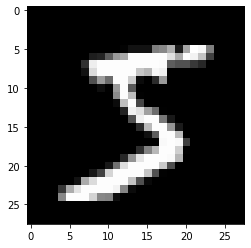

In [ ]:
#@title Pick image by number...
import matplotlib.pyplot as plt
imageNumber = 0 #@param {type:"slider", min:0, max:2999, step:1}
image = dataTest[imageNumber]
if image.dtype == "uint8":
  image = (image/255.).astype(np.float32)
plt.imshow(image,cmap="gray")
originalImage = image.copy()

### Upload your own image

In [ ]:
#@title Pick dataset (to resize the uploaded image to its size)
dataName = "CelebaGray" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]

desiredImageShape = dataNameToShape[dataName]

Saving albert.jpg to albert.jpg
User uploaded file "albert.jpg" with length 32840 bytes
Uploaded image:


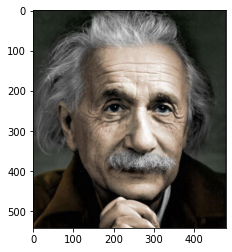

Uploaded image when resized:


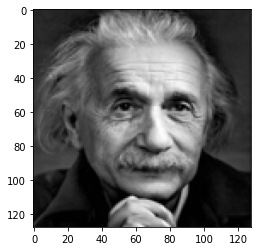

In [42]:
#@title Upload an image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
image = PIL.Image.open(fn)
print("Uploaded image:")
plt.figure()
plt.imshow(image)
plt.show()

if image.mode == "RGBA":
  image = image.convert("RGB")

image = image.resize(desiredImageShape[:2])
image = np.array(image)

if len(desiredImageShape) == 2 and len(image.shape) == 3:
  image = (0.2989*image[...,0] + 0.5870*image[...,1] + 0.1140*image[...,2]).astype(np.uint8)
if len(desiredImageShape) == 3 and len(image.shape) == 2:
  raise Exception("Dataset is RGB, but your image is Gray. Try again!")

print("Uploaded image when resized:")
plt.figure()
plt.imshow(image,cmap="gray")
plt.show()
image = image/255.
originalImage = image.copy()

## Add NAs to the test image


### Add Block NAs

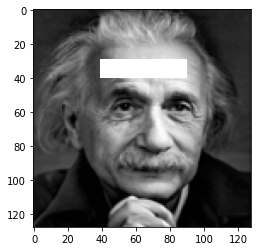

In [43]:
#@title Add Block NAs
topLeftRow =  30#@param {type:"number"}
topLeftColumn =  40#@param {type:"integer"}
bottomRightRow =  40#@param {type:"integer"}
bottomRightColumn =  90#@param {type:"integer"}
import matplotlib.pyplot as plt

addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn)
plt.imshow(image,cmap="gray")

### Add Single-Pixel NA

In [ ]:
#@title Add Single-Pixel NA
row =  20#@param {type:"number"}
column =  9#@param {type:"integer"}
import matplotlib.pyplot as plt

addNasPositions(image, [(row,column)])
plt.imshow(image,cmap="gray")

### Add Random NAs

In [ ]:
#@title Add Random NAs
probabilityOfSettingPixelToNa = 0.25 #@param {type:"slider", min:0, max:1, step:0.01}
addNasRandom(image,probabilityOfSettingPixelToNa)
import matplotlib.pyplot as plt
plt.imshow(image,cmap="gray")

## View image with NAs

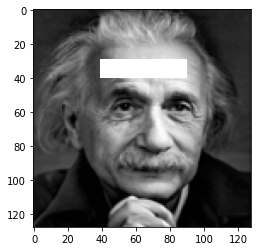

In [44]:
#@title View image with NAs
plt.imshow(image,cmap="gray")

## Inpaint!

### Pick dataset, distribution, k=number of distributions

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


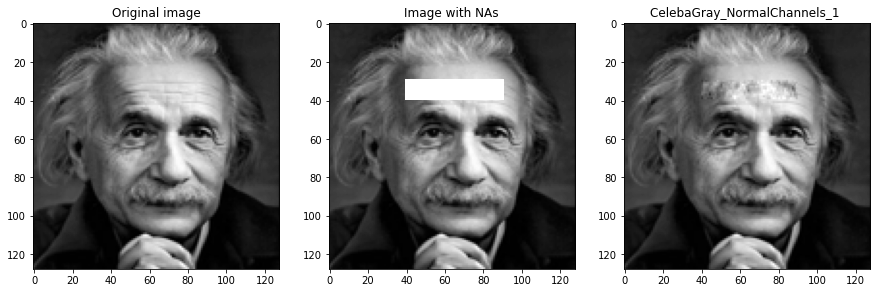

In [45]:
#@title Pick data, distribution, k=number of distributions
# %%time

imageWithNas = image

modelLocation = "your Google Drive account" #@param ["web", "memory", "your Google Drive account"]
dataName = "CelebaGray" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
distributionName = "NormalChannels" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
imputeABlockForMatrixNormalDistribution = True #@param {type:"boolean"}
k = 1 #@param {type:"slider", min:1, max:2, step:1}
resetInputedImageList = True #@param {type:"boolean"}
save = True #@param {type:"boolean"}

useModelFromMemory = False
if modelLocation == "web":
  import os
  directory = "serialized-models"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn" -O serialized-models-20200911T112745Z-001.zip && rm -rf /tmp/cookies.txt
    !unzip serialized-models-20200911T112745Z-001.zip
  location = "serialized-models/"
elif modelLocation == "memory":
  useModelFromMemory = True
else:
  location = 'drive/My Drive/serialized-models/'

if not useModelFromMemory:
  if modelLocation != "web":
    from google.colab import drive
    drive.mount('drive')
  r = deserialize(dataName,distributionName,k,location=location)

if distributionName == "Normal":
  inpaintedImage = ImputeViaNormalDistribution(
        fitDistribution=r[0],
        ifErrorReplaceByDistance=False,
        lambdaIdentity = 1e-6).impute(
        imageWithNas=imageWithNas,plot=False
    )
elif distributionName == "NormalChannels":
  inpaintedImage = ImputeViaNormalDistributionChannels(
        fitDistribution=r,
        ifErrorReplaceByDistance=False,
        lambdaIdentity = 1e-6).impute(
        imageWithNas=imageWithNas,plot=False
    )
elif distributionName == "MatrixNormalChannelsFaster" or distributionName == "MatrixNormalChannels":
  if imputeABlockForMatrixNormalDistribution:
    inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
        fitDistribution=r).imputeBlock(
              imageWithNas,
              topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
              plot=False
        )
  else:
    inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
      fitDistribution=r).impute(
            imageWithNas,
            plot=False,
            iterations=10000,
            threshold=1e-6,
            optimizer = tf.train.AdamOptimizer(),
            verboseAt = 1000
      )
elif distributionName == "PixelCnn":
  inpaintedImage = ImputeViaPixelCnnDistribution(r).impute(
        imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
    )

if resetInputedImageList:
  if 'inpaintedImages' in globals():
    del inpaintedImages
    del inpaintedTitles

if 'inpaintedImages' not in globals():
  inpaintedImages = []
  inpaintedTitles = []
inpaintedImages.append(inpaintedImage)
inpaintedTitles.append("{}_{}_{} {}".format(dataName,distributionName,k,"Block" if distributionName.startswith("Matrix") and imputeABlockForMatrixNormalDistribution else ""))

%matplotlib inline

fig, ax = plt.subplots(1,2+len(inpaintedImages),figsize=(15,15))
ax[0].title.set_text("Original image")
ax[0].imshow(originalImage,cmap="gray")
ax[1].title.set_text("Image with NAs")
ax[1].imshow(imageWithNas,cmap="gray")
for i in range(len(inpaintedImages)):
  ax[i+2].title.set_text(inpaintedTitles[i])
  ax[i+2].imshow(inpaintedImages[i],cmap="gray")

if save:
  plt.savefig('{}.eps'.format(inpaintedTitles[len(inpaintedTitles)-1]), format='eps')
  plt.savefig('{}.jpg'.format(inpaintedTitles[len(inpaintedTitles)-1]), format='jpg')

# Test full dataTest

In [ ]:
outDir = "F:/inpainting/data/cifar10-32x32/output"
maskDir = "F:/inpainting/data/test_masks/masks"
d = "32"

In [ ]:
#@title Pick dataset...
dataName = "Cifar10" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]

dataTrain,dataTest = dataNameToFunctionGetData[dataName]()
dataTrain[0].shape

50000
10000


(32, 32, 3)

In [ ]:
del dataTrain

In [ ]:
#@title Pick data, distribution, k=number of distributions
%%time

import numpy as np
from skimage import io

modelLocation = "web" #@param ["web", "memory", "your Google Drive account"]
dataName = "Cifar10" #@param ["Mnist", "CelebaGray", "Cifar10", "Celeba"]
distributionName = "Normal" #@param ["Normal", "NormalChannels", "MatrixNormalChannelsFaster", "MatrixNormalChannels", "PixelCnn"]
imputeABlockForMatrixNormalDistribution = True 
k = 1 #@param {type:"slider", min:1, max:2, step:1}

import os
if not os.path.isdir(outDir):
  os.mkdir(outDir)

useModelFromMemory = False
if modelLocation == "web":
  import os
  directory = "serialized-models"
  if not os.path.isdir(directory):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ZPCSyBjaFV0Xo_onnx1K49MyxJDlbVKn" -O serialized-models-20200911T112745Z-001.zip && rm -rf /tmp/cookies.txt
    !unzip serialized-models-20200911T112745Z-001.zip
  location = "serialized-models/"
elif modelLocation == "memory":
  useModelFromMemory = True
else:
  location = 'drive/My Drive/serialized-models/'

if not useModelFromMemory:
  if modelLocation != "web":
    from google.colab import drive
    drive.mount('drive')
  r = deserialize(dataName,distributionName,k,location=location)

for p in ["10","20","30","40","50"]:
  print(p)
  maskPng = maskDir + "/" + d + "/" + "{}_{}.png".format(d,p)
  maskTxt = maskDir + "/" + d + "/" + "{}_{}.txt".format(d,p)
  f = open(maskTxt, "r")
  topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn = int(f.readline()),int(f.readline()),int(f.readline()),int(f.readline())
  f.close()
  for i in range(len(dataTest)):
    image = dataTest[i].copy()
    if image.dtype == "uint8":
      image = (image/255.).astype(np.float32)
    addNasBlock(image, topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn)
    imageWithNas = image

    if distributionName == "Normal":
      inpaintedImage = ImputeViaNormalDistribution(
            fitDistribution=r[0],
            ifErrorReplaceByDistance=False,
            lambdaIdentity = 1e-6).impute(
            imageWithNas=imageWithNas,plot=False
        )
    elif distributionName == "NormalChannels":
      inpaintedImage = ImputeViaNormalDistributionChannels(
            fitDistribution=r,
            ifErrorReplaceByDistance=False,
            lambdaIdentity = 1e-6).impute(
            imageWithNas=imageWithNas,plot=False
        )
    elif distributionName == "MatrixNormalChannelsFaster" or distributionName == "MatrixNormalChannels":
      if imputeABlockForMatrixNormalDistribution:
        inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
            fitDistribution=r).imputeBlock(
                  imageWithNas,
                  topLeftRow,topLeftColumn,bottomRightRow,bottomRightColumn,
                  plot=False
            )
      else:
        inpaintedImage = ImputeViaMatrixNormalDistributionChannels(
          fitDistribution=r).impute(
                imageWithNas,
                plot=False,
                iterations=10000,
                threshold=1e-6,
                optimizer = tf.train.AdamOptimizer(),
                verboseAt = 1000
          )
    elif distributionName == "PixelCnn":
      inpaintedImage = ImputeViaPixelCnnDistribution(r).impute(
            imageWithNas,plot=True,iterations=1000,threshold=1e-6,optimizer=tf.train.AdamOptimizer(),verboseAt=100
        )
    io.imsave(outDir+'/{}/{}_{}/{}.png'.format(p,distributionName,k,i), inpaintedImage)
    
    

